In [1]:
!pip install -Uqq git+https://github.com/jaysinghr/DL-to-Diffusion@develop

In [1]:
#|default_exp sgd

# Accelerated SGD

In [3]:
#|export
import torch

from minimalai.datasets import *
from minimalai.conv import *
from minimalai.learner import *
from minimalai.activations import *
from minimalai.init import *

In [4]:
import pickle, gzip, math, os, time, shutil
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
# Define the keys for image and label
image_key, label_key = 'image', 'label'
# Specify the name of the dataset (e.g., "fashion_mnist")
dataset_name = "fashion_mnist"

# Load the dataset using the specified name
dataset_dict = load_dataset(dataset_name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Define the batch size for the data loader
batch_size = 1024
inputs_mean, inputs_std = 0.28, 0.35

In [8]:
# Define the function to transform the data inplace
@apply_inplace_transformation
def transform_images_inplace(batch):
    """
    Transform the images in the batch to tensors and flatten them inplace.

    Args:
    - batch (dict): A dictionary containing the batch of data.

    Returns:
    - dict: The transformed batch with images flattened as tensors.
    """
    batch[image_key] = [(TF.to_tensor(image) - inputs_mean) / inputs_std for image in batch[image_key]]
    return batch

# Apply the transform function `transform_images_inplace` to the dataset `loaded_dataset`
transformed_dataset = dataset_dict.with_transform(transform_images_inplace)

# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, batch_size, num_workers=4)

# Get the training data loader from the created data loaders
train_data_loader = data_loaders.train_loader

# Get a batch of data from the training data loader
inputs_batch, labels_batch = next(iter(train_data_loader))

In [9]:
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
activation_stats = ActivationStatisticsCallback(fc.risinstance(GeneralRelu))
callbacks = [DeviceCallback(), metrics, ProgressCallback(plot=True), activation_stats]


act_config = partial(GeneralRelu, negative_slope=0.1, subtract=0.4)
lr_finder_cbs = [DeviceCallback(), LRFinderCallback()]

## Optimizers

### SGD

In [10]:
#|export
class SGD:
    """Stochastic Gradient Descent optimizer."""

    def __init__(self, parameters, learning_rate, weight_decay=0.):
        """
        Initializes the SGD optimizer.

        Args:
        - parameters (iterable): Iterable of parameters to optimize.
        - learning_rate (float): The learning rate.
        - weight_decay (float, optional): Weight decay (L2 penalty) (default: 0).
        """
        self.params = list(parameters)
        self.lr = learning_rate
        self.wd = weight_decay
        self.i = 0

    def step(self):
        """
        Performs a single optimization step.

        Updates the parameters based on the gradients and the learning rate.
        """
        with torch.no_grad():
            for param in self.params:
                self.regularization_step(param)
                self.optimization_step(param)
        self.i += 1

    def optimization_step(self, param):
        """
        Performs the optimization step for a single parameter.

        Updates the parameter based on its gradient and the learning rate.
        """
        param -= param.grad * self.lr

    def regularization_step(self, param):
        """
        Performs the regularization step for a single parameter.

        Applies weight decay (L2 penalty) if the weight decay is non-zero.
        """
        if self.wd != 0:
            param *= 1 - self.lr * self.wd

    def zero_grad(self):
        """Clears the gradients of all optimized parameters."""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

In [11]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)
learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=0.4, 
                     callbacks=callbacks, 
                     optimizer_function=SGD)

accuracy,loss,epoch,train
0.768,0.647,0,train
0.824,0.497,0,eval
0.843,0.430,1,train
0.841,0.441,1,eval
0.862,0.380,2,train
0.855,0.402,2,eval


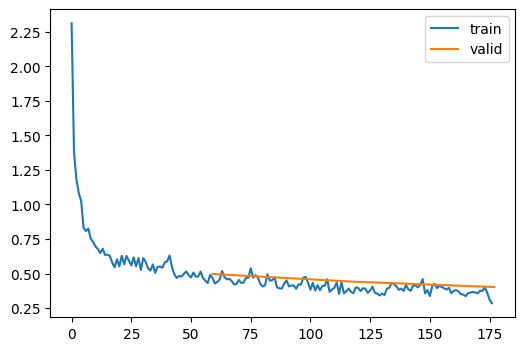

In [12]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

### Momentum

In [13]:
# Generate data
inputs = torch.linspace(-4, 4, 100)
targets = 1 - (inputs / 3) ** 2 + torch.randn(100) * 0.1

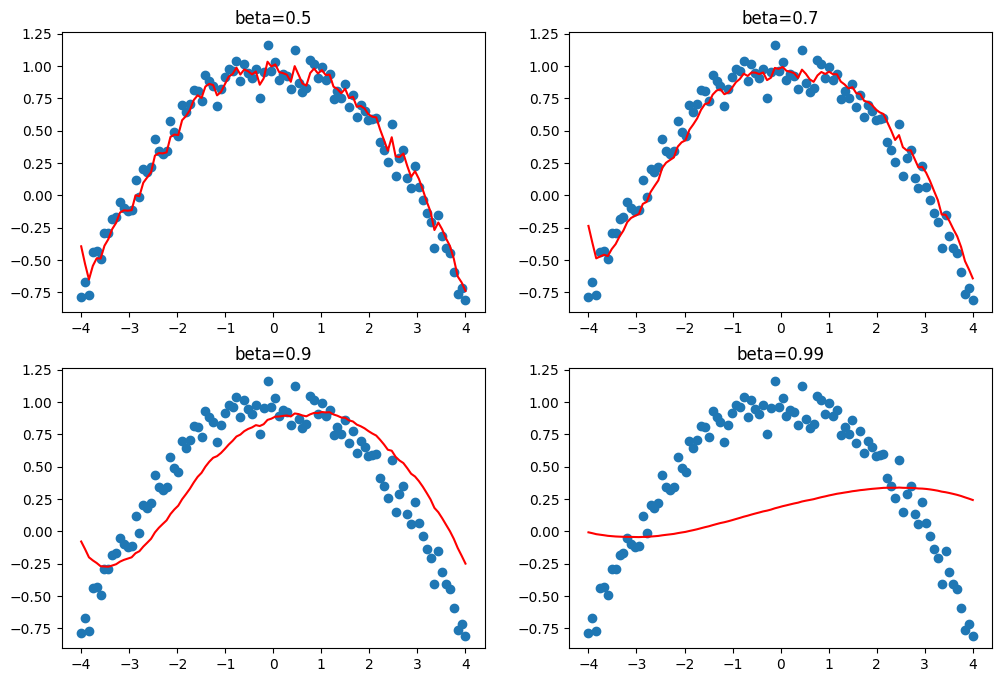

In [14]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Define values for beta
betas = [0.5, 0.7, 0.9, 0.99]

# Plot data for each beta value
for beta, ax in zip(betas, axs.flatten()):
    # Scatter plot of the data
    ax.scatter(inputs, targets)

    # Initialize variables for exponential moving average (EMA) calculation
    avg, res = 0, []

    # Calculate EMA
    for yi in targets:
        avg = beta * avg + (1 - beta) * yi
        res.append(avg)

    # Plot the EMA curve
    ax.plot(inputs, np.array(res), color='red')
    
    # Set title for the subplot
    ax.set_title(f'beta={beta}')

# Display the plots
plt.show()

In [15]:
#|export
class Momentum(SGD):
    """
    Momentum optimizer.

    Inherits from the SGD optimizer and adds momentum to the optimization step.
    """

    def __init__(self, parameters, learning_rate, weight_decay=0., momentum=0.9):
        """
        Initializes the Momentum optimizer.

        Args:
        - parameters (iterable): Iterable of parameters to optimize.
        - learning_rate (float): The learning rate.
        - weight_decay (float, optional): Weight decay (L2 penalty) (default: 0).
        - momentum (float, optional): Momentum factor (default: 0.9).
        """
        super().__init__(parameters, learning_rate=learning_rate, weight_decay=weight_decay)
        self.momentum = momentum

    def optimization_step(self, param):
        """
        Performs the optimization step with momentum for a single parameter.

        Updates the parameter based on its gradient, the learning rate, and momentum.
        """
        if not hasattr(param, 'grad_avg'):
            param.grad_avg = torch.zeros_like(param.grad)
        param.grad_avg = param.grad_avg * self.momentum + param.grad * (1 - self.momentum)
        param -= self.lr * param.grad_avg

In [16]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)
learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=1.5, 
                     callbacks=callbacks, 
                     optimizer_function=Momentum)

accuracy,loss,epoch,train
0.788,0.587,0,train
0.845,0.424,0,eval
0.866,0.368,1,train
0.866,0.379,1,eval
0.883,0.321,2,train
0.873,0.351,2,eval


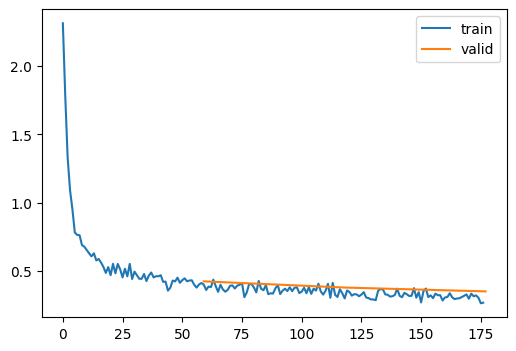

In [17]:
learn.fit(3)

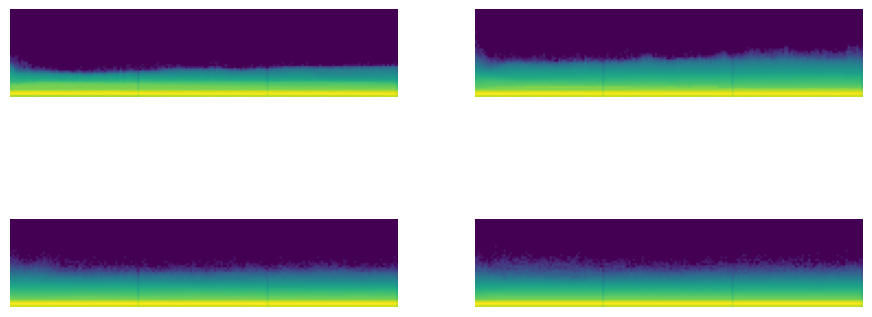

In [18]:
activation_stats.plot_color_dimensions()

### RMSProp

In [19]:
#|export
class RMSProp(SGD):
    """
    RMSProp optimizer.

    Inherits from the SGD optimizer and implements the RMSProp optimization algorithm.
    """

    def __init__(self, parameters, learning_rate, weight_decay=0., squared_momentum=0.99, epsilon=1e-5):
        """
        Initializes the RMSProp optimizer.

        Args:
        - parameters (iterable): Iterable of parameters to optimize.
        - learning_rate (float): The learning rate.
        - weight_decay (float, optional): Weight decay (L2 penalty) (default: 0).
        - squared_momentum (float, optional): Squared momentum factor (default: 0.99).
        - epsilon (float, optional): Small constant to avoid division by zero (default: 1e-5).
        """
        super().__init__(parameters, learning_rate=learning_rate, weight_decay=weight_decay)
        self.squared_momentum = squared_momentum
        self.epsilon = epsilon

    def optimization_step(self, param):
        """
        Performs the RMSProp optimization step for a single parameter.

        Updates the parameter based on its gradient, the learning rate, squared momentum, and epsilon.
        """
        if not hasattr(param, 'squared_avg'):
            param.squared_avg = param.grad ** 2
        param.squared_avg = param.squared_avg * self.squared_momentum + param.grad ** 2 * (1 - self.squared_momentum)
        param -= self.lr * param.grad / (param.squared_avg.sqrt() + self.epsilon)

accuracy,loss,epoch,train
0.769,0.659,0,train
0.826,0.482,0,eval
0.849,0.416,1,train
0.838,0.447,1,eval
0.864,0.372,2,train
0.857,0.398,2,eval


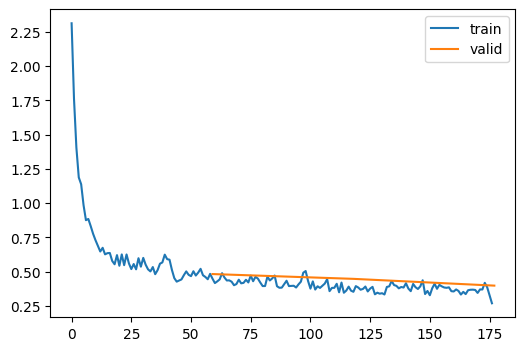

In [20]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)
learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=3e-3, 
                     callbacks=callbacks, 
                     optimizer_function=RMSProp)
learn.fit(3)

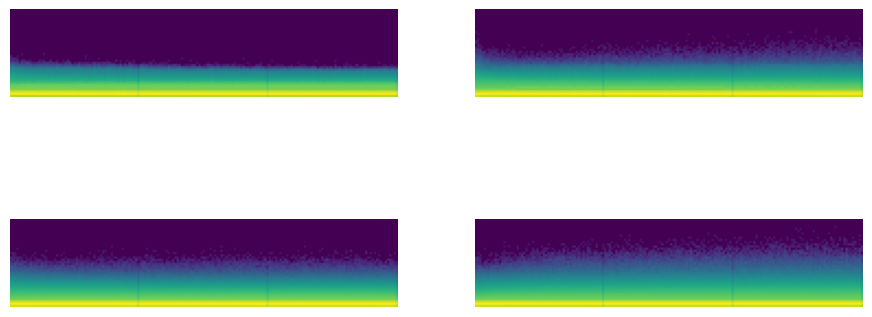

In [21]:
activation_stats.plot_color_dimensions()

### Adam

In [22]:
#|export
class Adam(SGD):
    """
    Adam optimizer.

    Inherits from the SGD optimizer and implements the Adam optimization algorithm.
    """

    def __init__(self, parameters, learning_rate, weight_decay=0., beta1=0.9, beta2=0.99, epsilon=1e-5):
        """
        Initializes the Adam optimizer.

        Args:
        - parameters (iterable): Iterable of parameters to optimize.
        - learning_rate (float): The learning rate.
        - weight_decay (float, optional): Weight decay (L2 penalty) (default: 0).
        - beta1 (float, optional): Exponential decay rate for the first moment estimates (default: 0.9).
        - beta2 (float, optional): Exponential decay rate for the second moment estimates (default: 0.99).
        - epsilon (float, optional): Small constant to avoid division by zero (default: 1e-5).
        """
        super().__init__(parameters, learning_rate=learning_rate, weight_decay=weight_decay)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def optimization_step(self, param):
        """
        Performs the Adam optimization step for a single parameter.

        Updates the parameter based on its gradient, the learning rate, beta1, beta2, and epsilon.
        """
        if not hasattr(param, 'avg'):
            param.avg = torch.zeros_like(param.grad.data)
        if not hasattr(param, 'squared_avg'):
            param.squared_avg = torch.zeros_like(param.grad.data)

        param.avg = self.beta1 * param.avg + (1 - self.beta1) * param.grad
        unbias_avg = param.avg / (1 - (self.beta1 ** (self.i + 1)))

        param.squared_avg = self.beta2 * param.squared_avg + (1 - self.beta2) * (param.grad ** 2)
        unbias_sqr_avg = param.squared_avg / (1 - (self.beta2 ** (self.i + 1)))

        param -= self.lr * unbias_avg / (unbias_sqr_avg + self.epsilon).sqrt()

accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval
0.868,0.363,1,train
0.869,0.372,1,eval
0.884,0.317,2,train
0.874,0.347,2,eval


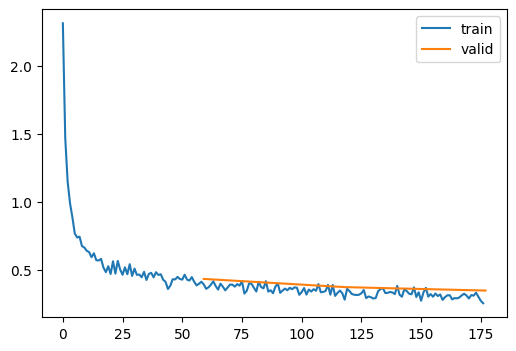

In [23]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)
learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=6e-3, 
                     callbacks=callbacks, 
                     optimizer_function=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [24]:
# Get names of attributes in lr_scheduler module that are likely to be classes or types
filtered_names = [
    attr_name
    for attr_name in dir(lr_scheduler)
    if attr_name[0].isupper() and attr_name[1].islower()
]

# Join the filtered names using a space
' '.join(filtered_names)

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [25]:
learn = TrainLearner(get_model(), 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=6e-3, 
                     callbacks=[DeviceCallback(), SingleBatchCallback()])
learn.fit(1)

In [26]:
# Get the `optimizer` attribute from the `learn` object
optimizer = learn.optimizer

# Get names of non-private attributes in `optimizer`
non_private_names = [
    attr_name
    for attr_name in dir(optimizer)
    if not attr_name.startswith('_')
]

# Join the non-private names using a space
' '.join(non_private_names)

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [27]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [28]:
# Get the first parameter from the model
param = next(iter(learn.model.parameters()))

# Get the state of the parameter from the optimizer's state dictionary
state = learn.optimizer.state[param]

In [29]:
state

{'momentum_buffer': None}

In [30]:
len(optimizer.param_groups)

1

In [31]:
param_groups = optimizer.param_groups[0]
list(param_groups)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [32]:
sched = lr_scheduler.CosineAnnealingLR(optimizer, 100)

In [33]:
sched.base_lrs

[0.006]

In [34]:
sched.get_last_lr()

[0.006]

In [35]:
#|export
def plot_scheduler_learning_rates(scheduler, steps):
    """
    Plot learning rates over a series of optimization steps using a scheduler.

    Args:
    - scheduler: The learning rate scheduler.
    - steps (int): The number of optimization steps.
    """
    learning_rates = [scheduler.get_last_lr()]
    for _ in range(steps):
        scheduler.optimizer.step()
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr())
    plt.plot(learning_rates)
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

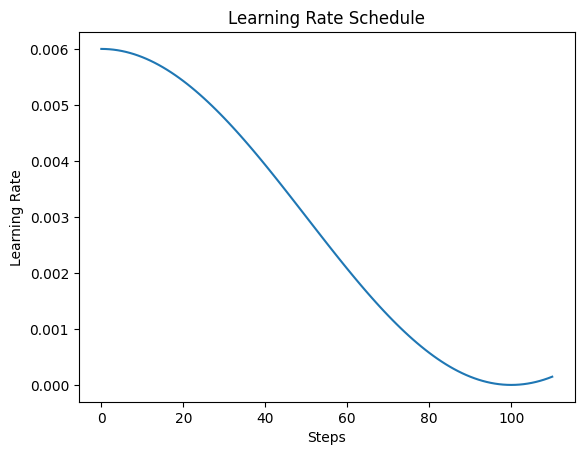

In [36]:
plot_scheduler_learning_rates(sched, 110)

### Scheduler callbacks

In [37]:
#|export
class BaseSchedulerCallback(Callback):
    """
    Base callback for learning rate scheduling.

    This callback is designed to work with a learning rate scheduler and is intended to be used during training.
    """

    def __init__(self, scheduler):
        """
        Initializes the BaseSchedCallback with a learning rate scheduler.

        Args:
        - scheduler: The learning rate scheduler.
        """
        self.scheduler = scheduler

    def before_fit(self, learner):
        """
        Callback method called before the training loop starts.

        This method initializes the scheduler for the optimizer used in the learner.
        """
        self.scheduler_obj = self.scheduler(learner.optimizer)

    def _step(self, learner):
        """
        Internal method to perform a scheduler step.

        This method is called during the training loop to update the scheduler.
        """
        if learner.training:
            self.scheduler_obj.step()

In [38]:
#|export
class BatchSchedulerCallback(BaseSchedulerCallback):
    """
    Callback for a scheduler that updates after each batch.

    Inherits from BaseSchedulerCallback and performs a step of the scheduler after each batch during training.
    """

    def after_batch(self, learner):
        """
        Callback after processing each batch.

        Performs a step of the scheduler if the learner is in training mode.
        """
        self._step(learner)

In [39]:
#|export
class HasLearnerCallback(Callback):
    """
    Callback for storing a reference to the learner during training.

    Inherits from Callback and stores a reference to the learner during training.
    """

    def before_fit(self, learner):
        """
        Callback before fitting the model.

        Stores a reference to the learner.
        """
        self.learner = learner

    def after_fit(self, learner):
        """
        Callback after fitting the model.

        Resets the reference to the learner.
        """
        self.learner = None

In [40]:
#|export
class RecorderCallback(Callback):
    """
    Callback for recording and plotting metrics during training.

    Inherits from Callback and records metrics specified in the dictionary `d` during training.
    """

    def __init__(self, **kwargs):
        """
        Initializes the RecorderCallback.

        Args:
        - kwargs: Dictionary of metrics to record.
        """
        self.metrics = kwargs

    def before_fit(self, learner):
        """
        Callback before fitting the model.

        Initializes the records dictionary and gets the parameter group from the optimizer.
        """
        self.records = {k: [] for k in self.metrics.keys()}
        self.param_group = learner.optimizer.param_groups[0]

    def after_batch(self, learner):
        """
        Callback after processing each batch.

        Records the metrics specified in the dictionary `d` for each batch.
        """
        if not learner.training:
            return
        for key, value_func in self.metrics.items():
            self.records[key].append(value_func(self))

    def plot(self):
        """
        Plots the recorded metrics.
        """
        for key, values in self.records.items():
            plt.plot(values, label=key)
            plt.legend()
            plt.show()

In [41]:
def get_learning_rate(callback):
    """
    Get the learning rate from a callback.

    Args:
    - callback: The callback containing the learning rate.

    Returns:
    - float: The learning rate.
    """
    return callback.param_group['lr']

In [42]:
len(data_loaders.train_loader)

59

In [43]:
# Calculate the total number of iterations for cosine annealing
total_iterations = 3 * len(data_loaders.train_loader)

# Create a partial function for the CosineAnnealingLR scheduler with T_max set to tmax
cosine_lr_scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=total_iterations)

accuracy,loss,epoch,train
0.796,0.552,0,train
0.853,0.402,0,eval
0.875,0.344,1,train
0.867,0.359,1,eval
0.889,0.301,2,train
0.875,0.341,2,eval


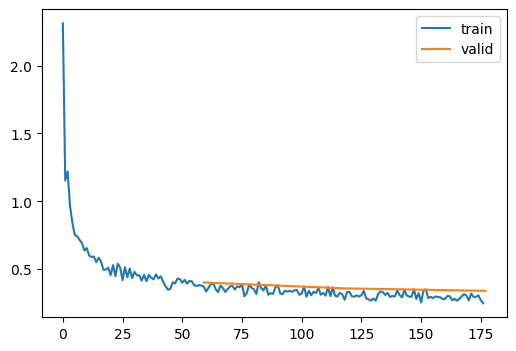

In [44]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)
recorder = RecorderCallback(lr = get_learning_rate)
xtra_callbacks = [BatchSchedulerCallback(cosine_lr_scheduler), recorder]
learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=2e-2, 
                     callbacks=callbacks+xtra_callbacks, 
                     optimizer_function=optim.AdamW)
learn.fit(3)

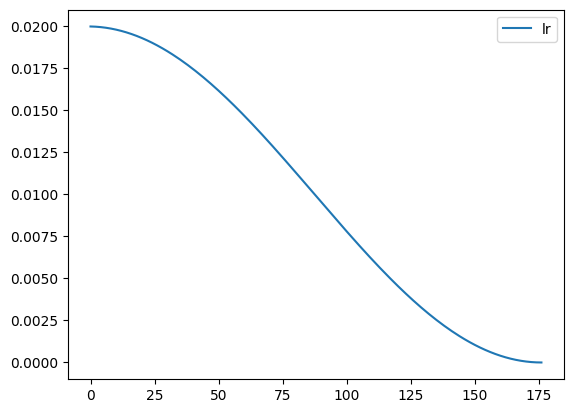

In [45]:
recorder.plot()

In [46]:
#|export
class EpochSchedulerCallback(BaseSchedulerCallback):
    """
    Callback for a scheduler that updates after each epoch.

    Inherits from BaseSchedulerCallback and performs a step of the scheduler after each epoch during training.
    """

    def after_epoch(self, learner):
        """
        Callback after completing each epoch.

        Performs a step of the scheduler if the learner is in training mode.
        """
        self._step(learner)

accuracy,loss,epoch,train
0.797,0.551,0,train
0.846,0.421,0,eval
0.873,0.347,1,train
0.871,0.355,1,eval
0.893,0.293,2,train
0.877,0.328,2,eval


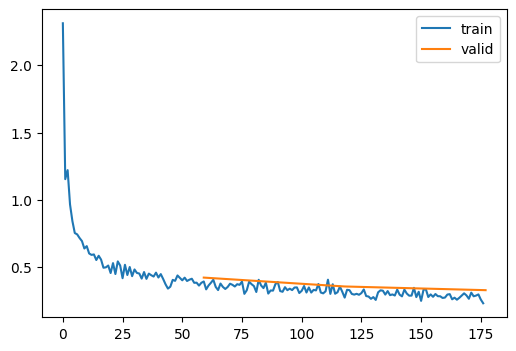

In [47]:
set_seed(42)
# Create a partial function for the CosineAnnealingLR scheduler with T_max set to tmax
cosine_lr_scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
xtra_callbacks = [EpochSchedulerCallback(cosine_lr_scheduler), recorder]

model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)

learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=2e-2, 
                     callbacks=callbacks+xtra_callbacks, 
                     optimizer_function=optim.AdamW)
learn.fit(3)

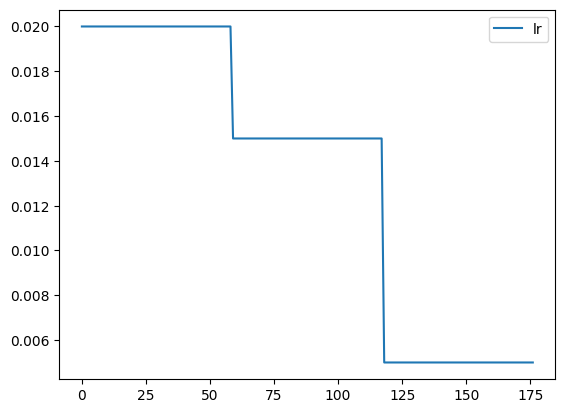

In [48]:
recorder.plot()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [49]:
def get_beta1(callback):
    """
    Get the value of the first element in the 'betas' list from a callback.

    Args:
    - callback: The callback containing the 'betas' list.

    Returns:
    - float: The value of the first element in the 'betas' list.
    """
    return callback.param_group['betas'][0]

# Create an instance of RecorderCB with lr set to the get_learning_rate function and mom set to the get_beta1 function
recorder = RecorderCallback(lr=get_learning_rate, mom=get_beta1)

accuracy,loss,epoch,train
0.772,0.647,0,train
0.840,0.482,0,eval
0.860,0.381,1,train
0.870,0.362,1,eval
0.885,0.310,2,train
0.876,0.341,2,eval
0.906,0.257,3,train
0.890,0.302,3,eval
0.919,0.221,4,train
0.899,0.279,4,eval


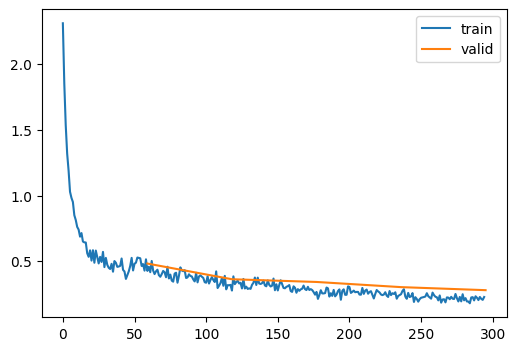

In [50]:
set_seed(42)
lr, epochs = 6e-2, 5
# Create a partial function for the CosineAnnealingLR scheduler with T_max set to tmax
tmax = epochs * len(data_loaders.train_loader)
cycle_lr_scheduler = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra_callbacks = [BatchSchedulerCallback(cycle_lr_scheduler), recorder]

model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_conv_weights)

learn = TrainLearner(model, 
                     data_loaders, 
                     F.cross_entropy, 
                     learning_rate=lr, 
                     callbacks=callbacks+xtra_callbacks, 
                     optimizer_function=optim.AdamW)
learn.fit(epochs)

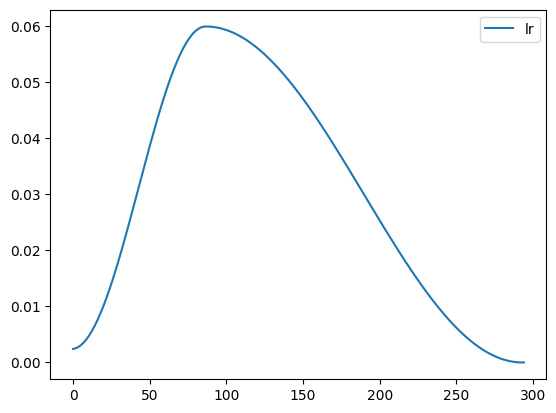

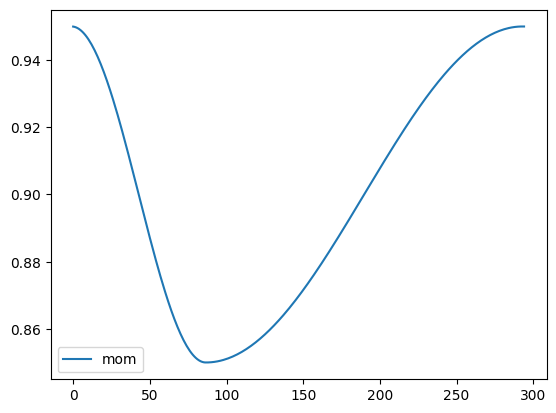

In [51]:
recorder.plot()

## Export -

In [52]:
import nbdev; nbdev.nbdev_export()